In [1]:
import numpy as np

import defines
from classic_MF import MF
# from classic_bin_MF import BinaryMF
from data_handler import Data_Handler
from embedded_QRS import embedded_QRS_model1
# from embedded_QRS_model2 import embedded_QRS_model2
from embedded_QRS_model3 import embedded_QRS_model3
# from hist_removal_per_user import hist_removal_per_user
from QRS_hist_removal_per_user import QRS_hist_removal_per_user
from QRS_amp_amp_per_user import QRS_amplitude_amp
from random_RS import random_RS
import visualiser
from embedded_QRS import randomize_init_params
from Q_data_prep_nn import improve_entanglemet


# input: reco_hit_index arr - for every recommendation - where the LOO item was
# output: HR@K arr
def create_HRK(hit_arr):
    hits_ind = np.zeros(11)
    for hit in hit_arr:
        if hit <= 10:
            hits_ind[hit] += 1
    _hit_arr = np.cumsum(hits_ind)
    _hit_arr = _hit_arr/len(hit_arr)
    return _hit_arr



# input:  uninteracted movies array
#         LOO item
#         scores array - in corelative order to uninteracted movies
# output: the index of the LOO item in the scores array
def get_LOO_index_in_scores_array(uninteracted_movies, LOO_item, reco_scores, search_reco_item_within_all_items=0):
    if search_reco_item_within_all_items == 0:
        t = np.array(uninteracted_movies)
        desired_inter_index_pos = np.where(t == LOO_item)[0][0]
    else:
        desired_inter_index_pos = LOO_item
    hit_index = (np.where(reco_scores.argsort()[::-1][:len(reco_scores)]==desired_inter_index_pos)[0])[0]+1
    return hit_index


# input:    1. list of tuples
#               A. userID - who we removed the interaction from
#               B. moviedId - which was removed from the user
#           2. if num_of_uninter_per_user == 0 - than taking all uninteracted movies
# output:   1. list of triples:
#               A. user index (encoded)
#               B. the movie index which removed (encoded)
#               C. list of uninteracted movies - contains the removed interaction movie (encoded)
def create_recommendation_sets(LOO, dh, num_of_uninter_per_user = 0):
    recommendation_sets = []
    for user, movieId in LOO:
        # getting all uninteracted movies
        uninteracted_movies = dh.get_uninteracted_movieId_to_user(user)

        # sample X of the uninteracted movies
        if num_of_uninter_per_user != 0:
            uninteracted_movies = np.random.choice(uninteracted_movies, num_of_uninter_per_user, replace=False)
        uninteracted_movies = [dh.convert_movieId_to_movie_encode(x) for x in uninteracted_movies]

        # convert the LOO movieId to encoded movie and add it to list
        LOO_encoded_movie = dh.convert_movieId_to_movie_encode(movieId)
        uninteracted_movies.append(LOO_encoded_movie)
        uninteracted_movies = list(set(uninteracted_movies))

        user_encoded = dh.convert_userId_to_user_encode(user)
        recommendation_sets.append((user_encoded, LOO_encoded_movie, uninteracted_movies))
    print("done creating recommendation sets")
    recommendation_sets = sorted(recommendation_sets)
    return recommendation_sets



def TEST_MODEL(recommendation_sets, MODEL, search_reco_item_within_all_items=0):
    reco_hit_index = []
    total_noise = 0
    for user, removed_movie, uninter_movies in recommendation_sets:
        # get recommendations from the model - on uninter_movies list
        reco_scores = MODEL.get_recommendation(user, uninter_movies, removed_movie)
        # getting the index of the LOO item from the recommendations
        reco_hit_index.append(get_LOO_index_in_scores_array(uninter_movies, removed_movie, reco_scores, search_reco_item_within_all_items))

        if search_reco_item_within_all_items:
            total_noise += sum(reco_scores[uninter_movies])
        else:
            total_noise += sum(reco_scores)


    reco_hit_index = np.array(reco_hit_index)
    HRK = create_HRK(reco_hit_index)
    print("---Total noise:", total_noise,"---")
    return HRK


def export_data(name_in):
    name = str(name_in)
    out_recommendation_sets = np.empty(len(recommendation_sets), dtype=object)
    out_recommendation_sets[:] = recommendation_sets
    with open('./exported_data/'+name+'_recommendation_sets_good.npy', 'wb') as f:
        np.save(f, out_recommendation_sets)
    with open('./exported_data/'+name+'_R_df_as_numpy_good.npy', 'wb') as f:
        np.save(f, R_df_as_numpy)
    with open('./exported_data/'+name+'_QRS_init_params.npy', 'wb') as f:
        np.save(f, QRS_init_params)
    with open('./exported_data/'+name+'_user_embedded_vecs.npy', 'wb') as f:
        np.save(f, user_embedded_vecs)
    with open('./exported_data/'+name+'_item_embedded_vecs.npy', 'wb') as f:
        np.save(f, item_embedded_vecs)
    with open('./exported_data/'+name+'_HRK_MF.npy', 'wb') as f:
        np.save(f, HRK_MF_SDG)
    with open('./exported_data/'+name+'_HRK_RAND_RECO.npy', 'wb') as f:
        np.save(f, HRK_RAND_RECO)   

        
def load_data(name_in):
    name = str(name_in)
    with open('./exported_data/'+name+'_recommendation_sets_good.npy', 'rb') as f:
        out_recommendation_sets = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_R_df_as_numpy_good.npy', 'rb') as f:
        R_df_as_numpy = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_QRS_init_params.npy', 'rb') as f:
        QRS_init_params = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_user_embedded_vecs.npy', 'rb') as f:
        user_embedded_vecs = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_item_embedded_vecs.npy', 'rb') as f:
        item_embedded_vecs = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_HRK_MF.npy', 'rb') as f:
        HRK_MF_SDG = np.load(f, allow_pickle=True)
    with open('./exported_data/'+name+'_HRK_RAND_RECO.npy', 'rb') as f:
        HRK_RAND_RECO = np.load(f, allow_pickle=True)

        
    return out_recommendation_sets, R_df_as_numpy, QRS_init_params, user_embedded_vecs, item_embedded_vecs, HRK_MF_SDG, HRK_RAND_RECO



In [2]:
LOAD_DATA = 0
export_name = '64_good2'
# export_data(export_name)

In [3]:
# ----------------------------- DATA PREPARATION ------------------------------------
HRK_list = []
HRK_list_name = []

random_data = 1

if LOAD_DATA:
    (recommendation_sets, R_df_as_numpy, QRS_init_params, user_embedded_vecs, item_embedded_vecs, HRK_MF_SDG, HRK_RAND_RECO) = load_data(export_name)
else:
    # to override the bad interaction in the random data
    # or to override the recommendation sets - use the if below for random data
    if random_data == 1:
        dh = Data_Handler(random_data=random_data)
        dh.add_bad_sample_for_every_user()
        LOO = dh.remove_last_interaction_for_every_user()
        R_df = dh.get_interaction_table()
        recommendation_sets = create_recommendation_sets(LOO, dh)
        R_df_as_numpy = R_df.to_numpy()
    else:
        with open('./exported_data/random_data_recommendation_sets_good.npy', 'rb') as f:
            recommendation_sets = np.load(f, allow_pickle=True)
        with open('./exported_data//random_data_R_df_as_numpy_good.npy', 'rb') as f:
            R_df_as_numpy = np.load(f, allow_pickle=True)

    QRS_init_params = randomize_init_params()

# user_items_removed_indices = [(x[0], x[1]) for x in recommendation_sets]
# visualiser.print_reco_matrix(R_df_as_numpy, user_items_removed_indices)


done adding bad interactions
done removing latest interactions
num of users: 16
num of movies: 128
done creating R_df
done creating recommendation sets


---Total noise: 809.476242532097 ---
Iteration: 1 ; error = 268.5350
Iteration: 2 ; error = 122.2152
Iteration: 3 ; error = 78.3916
Iteration: 4 ; error = 59.4337
Iteration: 5 ; error = 52.3204
Iteration: 6 ; error = 48.6009
Iteration: 7 ; error = 46.0897
Iteration: 8 ; error = 44.5115
Iteration: 9 ; error = 43.4679
Iteration: 10 ; error = 42.6906
Iteration: 11 ; error = 42.0659
Iteration: 12 ; error = 41.5402
Iteration: 13 ; error = 41.0852
Iteration: 14 ; error = 40.6845
Iteration: 15 ; error = 40.3274
Iteration: 16 ; error = 40.0065
Iteration: 17 ; error = 39.7166
Iteration: 18 ; error = 39.4535
Iteration: 19 ; error = 39.2141
Iteration: 20 ; error = 38.9956
Iteration: 21 ; error = 38.7957
Iteration: 22 ; error = 38.6127
Iteration: 23 ; error = 38.4449
Iteration: 24 ; error = 38.2907
Iteration: 25 ; error = 38.1490
Iteration: 26 ; error = 38.0185
Iteration: 27 ; error = 37.8983
Iteration: 28 ; error = 37.7875
Iteration: 29 ; error = 37.6853
Iteration: 30 ; error = 37.5909
Iteration:

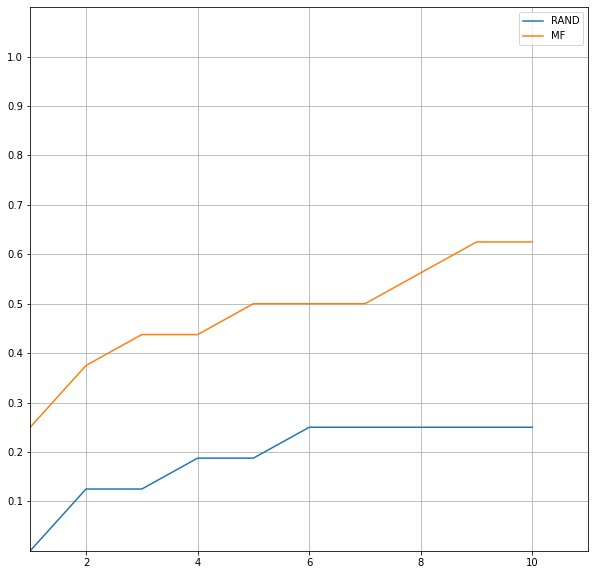

In [4]:
# ------------------------------------------ CLASSIC ALGOS -----------------------------------------
if LOAD_DATA == 0:

    # --------- RANDOM ---------
    RAND_RECO = random_RS()
    HRK_RAND_RECO = TEST_MODEL(recommendation_sets, RAND_RECO)

    # ----------- MF -----------
    SDG_MF = MF(R_df_as_numpy, defines._EMBEDDING_SIZE, alpha=0.2, beta=0.01, iterations=50)
    SDG_MF.train()
    HRK_MF_SDG = TEST_MODEL(recommendation_sets, SDG_MF)
    # if random_data == 1:
    #     visualiser.print_reco_matrix(R_df_as_numpy, user_items_removed_indices, SDG_MF.full_matrix(), all_positive=0, digits_after_point=2)

    # ------ old MF -----
    #  BinMF = BinaryMF(R_df_as_numpy, defines._EMBEDDING_SIZE, 7000)
    #  BinMF.train()
    #  BinMF.update_predictions()
    #  HRK_MF_BIN = TEST_MODEL(recommendation_sets, BinMF)


HRK_list.append(HRK_RAND_RECO)
HRK_list_name.append("RAND")

HRK_list.append(HRK_MF_SDG)
HRK_list_name.append("MF")

visualiser.plot_HRK(HRK_list, HRK_list_name)


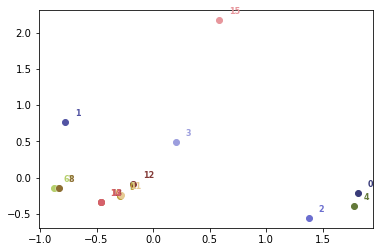

In [5]:
if LOAD_DATA == 0:
    user_embedded_vecs = SDG_MF.get_user_embedded_vectors()
    item_embedded_vecs = SDG_MF.get_item_embedded_vectors()
#     user_embedded_vecs = BinMF.get_user_embedded_vectors()
#     item_embedded_vecs = BinMF.get_item_embedded_vectors()

visualiser.plot_embedded_vecs(user_embedded_vecs)


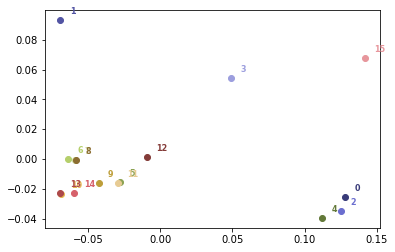

13.75

------- TRAINING EMBEDDED ITEM RECOMMENDATION SYS -------
training step: 0
total_cost: 9.534344493576192
------------------------------------ 

training step: 1
total_cost: 1.8413454018954272
------------------------------------ 

training step: 2
total_cost: 1.7368700759077003
------------------------------------ 

training step: 3


In [ ]:
models_to_test = [1]
QRS_train_steps = 20

for model in models_to_test:
    if model == 1:
        QRS_model = embedded_QRS_model1(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    if model == 2:
        QRS_model = embedded_QRS_model2(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    if model == 3:
        QRS_model = embedded_QRS_model3(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    
    QRS_model.train()

    print("\n\nTESTING QRS MODEL ", model)
    HRK_list.append(TEST_MODEL(recommendation_sets, QRS_model, search_reco_item_within_all_items=1))
    HRK_list_name.append("QRS_{}".format(model))
    visualiser.plot_HRK(HRK_list, HRK_list_name)
    
    # ------------------------------- HIST REMOVAL ------------------------------
    QRS_reco_matrix = QRS_model.get_QRS_reco_matrix()
    QRS_opt_params = QRS_model.get_QRS_opt_params()
    QRS_HistRem = QRS_hist_removal_per_user(R_df_as_numpy, QRS_reco_matrix, user_embedded_vecs, QRS_opt_params)
    QRS_HistRem.train()

    print("\n\nTESTING QRS HIST REMOVAL ", model)
    HRK_list.append(TEST_MODEL(recommendation_sets, QRS_HistRem, search_reco_item_within_all_items=1))
    HRK_list_name.append("QRS_HistRem_{}".format(model))
    visualiser.plot_HRK(HRK_list, HRK_list_name)

    # ------------------------------- AMPLITUDE AMPLIFY ------------------------------
#     QRS_HistRem_opt_params = QRS_HistRem.get_QRS_opt_params()
#     QRS_HistRem_reco_matrix = QRS_HistRem.get_QRS_reco_matrix()

#     QRS_HistRem_AmpAmp = QRS_amplitude_amp(R_df_as_numpy, QRS_HistRem_reco_matrix, user_embedded_vecs, QRS_opt_params, QRS_HistRem_opt_params)
#     QRS_HistRem_AmpAmp.train()

#     print("\n\nTESTING QRS AMP AMP")
#     HRK_list.append(TEST_MODEL(recommendation_sets, QRS_HistRem_AmpAmp, search_reco_item_within_all_items=1))
#     HRK_list_name.append("QRS_Amp_{}".format(model))
#     visualiser.plot_HRK(HRK_list, HRK_list_name)

        
    


In [ ]:

(R_df_as_numpy,recommendation_sets)=improve_entanglemet(R_df_as_numpy,10, recommendation_sets)


SDG_MF = MF(R_df_as_numpy, defines._EMBEDDING_SIZE, alpha=0.2, beta=0.01, iterations=50)
SDG_MF.train()

HRK_MF_SDG = TEST_MODEL(recommendation_sets, SDG_MF)
HRK_list.append(HRK_MF_SDG)
HRK_list_name.append("MF_Ent_Opt")


user_embedded_vecs = SDG_MF.get_user_embedded_vectors()
item_embedded_vecs = SDG_MF.get_item_embedded_vectors()




for model in models_to_test:
    if model == 1:
        QRS_model = embedded_QRS_model1(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    if model == 2:
        QRS_model = embedded_QRS_model2(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    if model == 3:
        QRS_model = embedded_QRS_model3(R_df_as_numpy, user_embedded_vecs, item_embedded_vecs, QRS_init_params, train_steps=QRS_train_steps)
    
    QRS_model.train()

    print("\n\nTESTING QRS MODEL ", model)
    HRK_list.append(TEST_MODEL(recommendation_sets, QRS_model, search_reco_item_within_all_items=1))
    HRK_list_name.append("QRS_Ent_Opt_{}".format(model))
    visualiser.plot_HRK(HRK_list, HRK_list_name)
    
    # ------------------------------- HIST REMOVAL ------------------------------
    QRS_reco_matrix = QRS_model.get_QRS_reco_matrix()
    QRS_opt_params = QRS_model.get_QRS_opt_params()
    QRS_HistRem = QRS_hist_removal_per_user(R_df_as_numpy, QRS_reco_matrix, user_embedded_vecs, QRS_opt_params)
    QRS_HistRem.train()

    print("\n\nTESTING QRS HIST REMOVAL ", model)
    HRK_list.append(TEST_MODEL(recommendation_sets, QRS_HistRem, search_reco_item_within_all_items=1))
    HRK_list_name.append("QRS_Ent_Opt_HistRem_{}".format(model))
    visualiser.plot_HRK(HRK_list, HRK_list_name)

    